# Collating and cleaning fish data
This notebook collates and cleans the fish tracking data from [source](https://dx.doi.org/10.17617/3.4y).<br>
The dataset we are interested in are those files prepended with *reversals3m_1024_dotbot_20181025_105202*<br>
The data consists of the tracking observation data for approximately 1024 sunbleak fish in a 3m tank. Each fish has its observations contained in an individual .npz file, which we will combine. There are 40 frames per second for 500 seconds.

## Collating the fish data

In [1]:
# Import the usual stuff

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Specify the folder location for the data

data_folder_location = "D:\\Data\\TRex data\\results_accurate_no_posture_data\\media\\recordings\\tristan\\paper\\2.Jun.20\\accurate_no_posture\\data\\reversals3m_1024_dotbot_20181025_105202\\"

### Warning: the following code takes about 1min20s to compute this cell. Concatenating dataframes is inefficient (it's better to concatenate lists and then convert to DataFrame at end).
 I will try to improve this when I get a chance, but for now it works. 

In [2]:
# This loads the individual files and stores them as a dataframe, then appends that dataframe to the previous dataframes
# The quantities we are interested in are the x and y positions, the time, the frame, and the fish number

# We will build the dataframe one fish at a time, but instead of initialising an empty dataframe we will start with the first fish, Fish 0

with np.load(data_folder_location+'reversals3m_1024_dotbot_20181025_105202.stitched_fish'+'0'+'.npz') as fish_data:
    npz = fish_data
    Fish = list(np.full(npz['time'].shape, 0, dtype=int))
    x = list(npz['X#wcentroid'])
    y = list(npz['Y#wcentroid'])
    t = list(npz['time'])
    frame = list(npz['frame'])
    fish_dict = {'Fish':Fish, 't':t, 'x':x, 'y':y, 'frame':frame}
    df = pd.DataFrame(fish_dict)

# We now iterate through the rest of the fish, creating and appending a dataframe for each fish to df.

for i in range(1,1126):

    with np.load(data_folder_location+'reversals3m_1024_dotbot_20181025_105202.stitched_fish'+str(i)+'.npz') as fish_data:
        npz = fish_data
        Fish = list(np.full(npz['time'].shape, i, dtype=int))
        x = list(npz['X#wcentroid'])
        y = list(npz['Y#wcentroid'])
        t = list(npz['time'])
        frame = list(npz['frame'])
        fish_dict = {'Fish':Fish, 't':t, 'x':x, 'y':y, 'frame':frame}
        df = pd.concat([df, pd.DataFrame(fish_dict)])



df = df.sort_values(['Fish','frame'])
print(df)

       Fish           t          x           y    frame
0         0    0.224779  72.011169  119.371750      8.0
1         0    0.249735        inf         inf      9.0
2         0    0.274696  72.386383  119.354118     10.0
3         0    0.299712  72.611839  119.335945     11.0
4         0    0.324633  72.851936  119.275497     12.0
...     ...         ...        ...         ...      ...
20009  1125  499.824249  74.614189  117.827614  20009.0
20010  1125  499.849274  74.443268  117.816742  20010.0
20011  1125  499.874268  74.245605  117.802887  20011.0
20012  1125  499.899292  73.972771  117.835457  20012.0
20013  1125  499.924164  73.792877  117.878098  20013.0

[22533844 rows x 5 columns]


## Cleaning the fish data

In [3]:
# Now that we have all of our data in a big dataframe, we can check to see if it is clean
# Let's start by looking at the datatypes of the columns

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22533844 entries, 0 to 20013
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Fish    int32  
 1   t       float32
 2   x       float32
 3   y       float32
 4   frame   float32
dtypes: float32(4), int32(1)
memory usage: 601.7 MB
None


In [4]:
# This looks good - let's check out the max and min values
print('mins are: \n', df.min(), '\n')
print('maxs are: \n', df.max())

mins are: 
 Fish     0.000000
t        0.000000
x        2.974756
y        3.064423
frame    0.000000
dtype: float64 

maxs are: 
 Fish     1.125000e+03
t        4.999242e+02
x                 inf
y                 inf
frame    2.001300e+04
dtype: float64


In [5]:
# Ok, this is a problem. The mins are fine, but the max contains "inf" in the x and y columns. This happens when TRex can't distinguish between two fish.
# We need to clean this up by replacing inf with an appropriate number.


# It seems that whenever x is inf, then y is also inf. We should first check this is true. 
print('x is "inf" if and only if y is also "inf": ', (df['x']==float('inf')).equals(df['y']==float('inf')))



x is "inf" if and only if y is also "inf":  True


### Replacing the "inf" values
The easiest method would be to just replace all inf with NaN, then sort by fish and time and fill forward. This would mean that any "inf" values are replaced by the value that the fish last had. The problem with this is that if there are multiple "inf" entries in a row, it might make the fish look like it is standing still and then jumping forward. A more sophisticated method would be to linearly interpolate the position of the fish between the value it had before the "inf" entries, and the value it had after.

In [6]:
# Let's do the quick and dirty thing first, and come back and improve this later

# First replace all the "inf" with NaN
df.loc[df['x'] == float('inf'), 'x'] = np.nan
df.loc[df['y'] == float('inf'), 'y'] = np.nan

# Now use forward fill to fill in the NaN values.
df = df.ffill(axis=0)

# Verify that we've removed the inf and the max is more sensible.  
print('number of "inf" in the x column: ', df['x'].isna().sum())
print('number of "inf" in the y column: ', df['y'].isna().sum())
print('maxs are: \n', df.max())

number of "inf" in the x column:  0
number of "inf" in the y column:  0
maxs are: 
 Fish      1125.000000
t          499.924164
x          119.099846
y          122.004288
frame    20013.000000
dtype: float64


## Simple data exploration

In [7]:
# The maximum and minimum ranges for the x and y values are:

print('x minimum is: ', df['x'].min())
print('x maximum is: ', df['x'].max())
print('y minimum is: ', df['y'].min())
print('y maximum is: ', df['y'].max())


# Given this, it seems a sensible range for x and y is x in (0, 125), y in (0,125).
xmin = 0
xmax = 120
ymin = 0
ymax = 125

x minimum is:  2.9747562408447266
x maximum is:  119.09984588623047
y minimum is:  3.064422607421875
y maximum is:  122.00428771972656


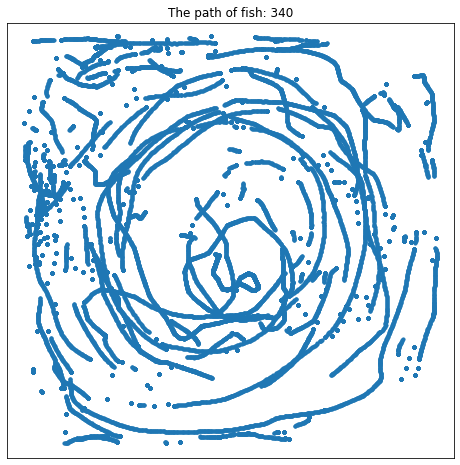

In [8]:
# Let's look at a random fish, and look at its (x,y) position over time
# First, pick a random fish 

testfish = 340

fig, ax = plt.subplots()


ax.scatter(df[(df['Fish'] == testfish)]['x'], df[(df['Fish'] == testfish)]['y'], s=10, c='tab:blue')


ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

ax.set_title(str("The path of fish: " + str(testfish)))

fig.set_size_inches(8,8)
plt.show()

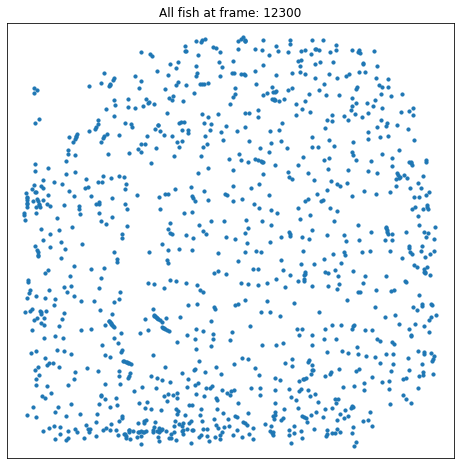

In [15]:
# Alternatively, we can look at all the fish at a given frame
# First, pick a random frame
testframe= 12300


fig, ax = plt.subplots()


ax.scatter(df[(df['frame'] == testframe)]['x'], df[(df['frame'] == testframe)]['y'], s=10, c='tab:blue')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

ax.set_title(str("All fish at frame: " + str(testframe)))

fig.set_size_inches(8,8)
plt.show()

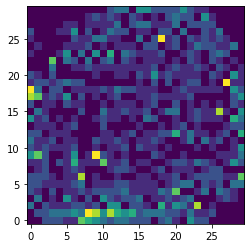

In [14]:
# It would be interesting to see a heatmap of the density of fish
# The quick and dirty way of doing this is via numpys histogram2d

# For a random time, this is the heatmap
heatmap, xedges, yedges = np.histogram2d(df[(df['frame'] == testframe)]['x'], df[(df['frame'] == testframe)]['y'], bins=(30,30))
plt.imshow(heatmap.T, origin='lower')

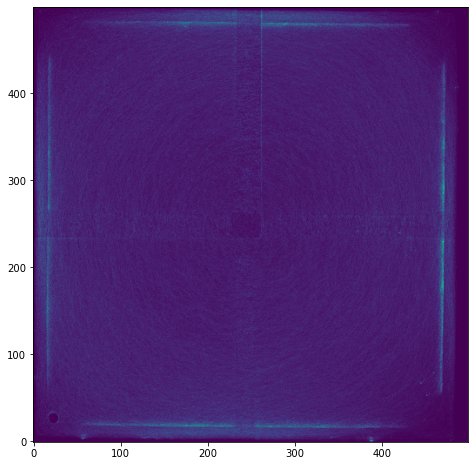

In [36]:
# We can also do this for all x and y values in a given timeframe, and in particular, for the entire dataset

heatmap, xedges, yedges = np.histogram2d(df[(df['frame'] > 0) & (df['frame'] < 20000)]['x'], df[(df['frame'] > 0) & (df['frame'] < 20000)]['y'], bins=(500,500))
plt.figure(figsize=(8,8))

plt.imshow(heatmap.T, origin='lower')

In [ ]:
# In the previous image we saw some interesting things!
# Averaged over the whole time, the fish tend to congregate around the outside of the tank
# We also saw some artifacts of the video stitching, where footage from 4 cameras was stitched together to form one image
# Both of these are things we should keep in mind when we are doing our data analysis later